<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/HookedCursiveTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HookedCursiveTransformer

https://github.com/zwimpee/cursivetransformer/issues/26

We will find this post particularly useful: https://arena3-chapter1-transformer-interp.streamlit.app/[1.1]_Transformer_from_Scratch
As well as this notebook: https://colab.research.google.com/drive/1bZkkJd8pAVnSN23svyszZ3f4WrnYKN_3?usp=sharing

# Setup

In [1]:
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

# Import cursivetransformer modules
from cursivetransformer.model import get_all_args, get_checkpoint
from cursivetransformer.data import create_datasets, offsets_to_strokes
from cursivetransformer.sample import generate, generate_n_words, plot_strokes

# Import TransformerLens modules

import dataclasses
import logging
import os
import re
from pathlib import Path
from typing import Dict, Optional, Union

from transformer_lens import HookedTransformer
from transformer_lens.components import HookedAttention, HookedMLP
import transformer_lens.utils as utils
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig


# Import other necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gradio as gr
import pprint
import json
from datasets import load_dataset
from IPython.display import HTML, display
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import einops
from einops import rearrange

# Move input to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

model, optimizer, scheduler, step, best_loss = get_checkpoint(args)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Fo

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples
Number of Transformer parameters: 368064
Model #params: 397184
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_che

wandb:   1 of 1 files downloaded.  


## Classes

In [ ]:
class HookedCursiveTransformerConfig(HookedTransformerConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Additional parameters for cross-attention and context
        self.d_model_c = kwargs.get('d_model_c', self.d_model)
        self.n_ctx_c = kwargs.get('n_ctx_c', self.n_ctx)
        self.d_vocab_c = kwargs.get('d_vocab_c', self.d_vocab)
        self.use_cross_attention = kwargs.get('use_cross_attention', True)

class HookedCursiveTransformer(HookedTransformer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.cfg = cfg

        # Embedding layers for the context input
        self.embed_c = nn.Embedding(cfg.d_vocab_c, cfg.d_model_c)
        self.pos_embed_c = nn.Embedding(cfg.n_ctx_c, cfg.d_model_c)

        # Override the transformer blocks with custom blocks that include cross-attention
        self.blocks = nn.ModuleList([
            CustomTransformerBlock(self.cfg, layer_idx)
            for layer_idx in range(self.cfg.n_layers)
        ])

        # Update the final layer norm to match your model
        self.ln_final = nn.LayerNorm(self.cfg.d_model)

    def forward(self, x, c, return_type="logits", **kwargs):
        # Embedding and positional encoding for x
        x_tokens = self.embed(x)  # [batch, seq_len, d_model]
        x_positions = self.pos_embed(torch.arange(x_tokens.size(1), device=x_tokens.device))  # [seq_len, d_model]
        x = x_tokens + x_positions

        # Embedding and positional encoding for c
        c_tokens = self.embed_c(c)  # [batch, context_len, d_model_c]
        c_positions = self.pos_embed_c(torch.arange(c_tokens.size(1), device=c_tokens.device))  # [context_len, d_model_c]
        c = c_tokens + c_positions

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, c, **kwargs)

        x = self.ln_final(x)
        logits = self.unembed(x)

        if return_type == "logits":
            return logits
        elif return_type == "loss":
            targets = kwargs.get('targets')
            if targets is None:
                raise ValueError("Targets must be provided when return_type is 'loss'")
            loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return loss
        elif return_type == "both":
            return logits, kwargs.get('cache', None)
        else:
            raise ValueError(f"Invalid return_type: {return_type}")

class HookedAttention(nn.Module):
    def __init__(self, cfg, is_cross_attention=False, layer_idx=None):
        super().__init__()
        self.cfg = cfg
        self.is_cross_attention = is_cross_attention
        self.layer_idx = layer_idx
        self.W_Q = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model, cfg.d_head))
        if is_cross_attention:
            self.W_K = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model_c, cfg.d_head))
            self.W_V = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model_c, cfg.d_head))
        else:
            self.W_K = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model, cfg.d_head))
            self.W_V = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_model, cfg.d_head))
        self.W_O = nn.Parameter(torch.empty(cfg.n_heads, cfg.d_head, cfg.d_model))
        # Biases
        self.b_Q = nn.Parameter(torch.zeros(cfg.n_heads, cfg.d_head))
        self.b_K = nn.Parameter(torch.zeros(cfg.n_heads, cfg.d_head))
        self.b_V = nn.Parameter(torch.zeros(cfg.n_heads, cfg.d_head))
        self.b_O = nn.Parameter(torch.zeros(cfg.d_model))
        # Register hooks if needed

    def forward(self, x, context=None, **kwargs):
        # x: [batch, seq_len, d_model]
        if self.is_cross_attention:
            if context is None:
                raise ValueError("Context must be provided for cross-attention")
            k_input = context
            v_input = context
        else:
            k_input = x
            v_input = x

        # Compute queries, keys, values
        q = einsum('b t d, h d e -> b h t e', x, self.W_Q) + self.b_Q  # [batch, n_heads, seq_len, d_head]
        k = einsum('b s d, h d e -> b h s e', k_input, self.W_K) + self.b_K  # [batch, n_heads, seq_len_k, d_head]
        v = einsum('b s d, h d e -> b h s e', v_input, self.W_V) + self.b_V  # [batch, n_heads, seq_len_v, d_head]

        # Compute attention scores
        attn_scores = einsum('b h t e, b h s e -> b h t s', q, k) / math.sqrt(self.cfg.d_head)

        # Apply causal mask if needed (for self-attention)
        if not self.is_cross_attention and self.cfg.attn_only:
            attn_scores = self.apply_causal_mask(attn_scores)

        # Apply softmax to get attention probabilities
        attn_probs = nn.functional.softmax(attn_scores, dim=-1)

        # Save attention patterns for analysis
        if kwargs.get('cache', None) is not None:
            cache = kwargs['cache']
            hook_name = f'blocks.{self.layer_idx}.{"cross_attn" if self.is_cross_attention else "attn"}.hook_pattern'
            cache[hook_name] = attn_probs.detach()

        # Compute attention output
        attn_output = einsum('b h t s, b h s e -> b h t e', attn_probs, v)
        attn_output = einsum('b h t e, h e d -> b t d', attn_output, self.W_O) + self.b_O  # [batch, seq_len, d_model]

        return attn_output

    def apply_causal_mask(self, attn_scores):
        # Implement causal masking logic here if needed
        return attn_scores


class HookedTransformerBlock(nn.Module):
    def __init__(self, cfg, layer_idx):
        super().__init__()
        self.cfg = cfg
        self.layer_idx = layer_idx

        # Layer norms
        self.ln1 = nn.LayerNorm(cfg.d_model)
        self.ln2 = nn.LayerNorm(cfg.d_model)
        self.ln3 = nn.LayerNorm(cfg.d_model)

        # Self-attention using HookedAttention
        self.attn = HookedAttention(cfg, layer_idx=layer_idx)

        # Cross-attention using modified HookedAttention
        self.cross_attn = HookedAttention(cfg, is_cross_attention=True, layer_idx=layer_idx)

        # MLP
        self.mlp = HookedMLP(cfg, layer_idx=layer_idx)

    def forward(self, x, c, **kwargs):
        # Self-attention
        x = x + self.attn(self.ln1(x), **kwargs)

        # Cross-attention
        x = x + self.cross_attn(self.ln2(x), context=c, **kwargs)

        # MLP
        x = x + self.mlp(self.ln3(x), **kwargs)

        return x



# Functions

In [65]:
def convert_cursivetransformer_model_config(args):
    cfg_dict = {
        # Standard parameters
        "d_model": args.n_embd,
        "n_layers": args.n_layer,
        "d_mlp": args.n_embd * 4,
        "d_head": args.n_embd // args.n_ctx_head,
        "n_heads": args.n_ctx_head,
        "n_ctx": args.max_seq_length,
        "d_vocab": args.vocab_size,
        "tokenizer_name": None,
        "act_fn": "gelu_new",
        "attn_only": False,
        "final_rms": False,
        "original_architecture": "cursivetransformer",
        "normalization_type": "LN",
        "init_weights": False,
        "device": args.device,
        # Additional parameters for cross-attention
        "d_model_c": args.n_embd2,
        "n_ctx_c": args.context_block_size,
        "d_vocab_c": args.context_vocab_size,
        "use_cross_attention": True,
    }
    cfg = CustomTransformerConfig.from_dict(cfg_dict)
    return cfg


def fill_missing_keys(model, state_dict):
    """Takes in a state dict from a pretrained model, and fills in any missing keys with the default initialization.

    This function is assumed to be run before weights are initialized.

    Args:
        state_dict (dict): State dict from a pretrained model

    Returns:
        dict: State dict with missing keys filled in
    """
    # Get the default state dict
    default_state_dict = model.state_dict()
    # Get the keys that are missing from the pretrained model
    missing_keys = set(default_state_dict.keys()) - set(state_dict.keys())
    # Fill in the missing keys with the default initialization
    for key in missing_keys:
        if "hf_model" in key:
            # Skip keys that are from the HuggingFace model, if loading from HF.
            continue
        if "W_" in key:
            logging.warning(
                "Missing key for a weight matrix in pretrained, filled in with an empty tensor: {}".format(
                    key
                )
            )
        state_dict[key] = default_state_dict[key]
    return state_dict

def convert_cursivetransformer_weights(model, cfg: HookedTransformerConfig):
    state_dict = {}
    state_dict["embed.W_E"] = model.transformer.wte.weight
    state_dict["pos_embed.W_pos"] = model.transformer.wpe.weight

    for l in range(cfg.n_layers):
        # print(f"Layer {l}:")
        state_dict[f"blocks.{l}.ln1.w"] = model.transformer.h[l].ln_1.weight
        state_dict[f"blocks.{l}.ln1.b"] = model.transformer.h[l].ln_1.bias

        # Fetch the weights
        W = model.transformer.h[l].attn.c_attn.weight
        # print(f"W shape: {W.shape}")

        # Correctly split W along dim=0 (out_features)
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=0)
        # print(f"W_Q shape: {W_Q.shape}")

        total_head_dim = W_Q.shape[0]  # Number of rows in W_Q
        if total_head_dim % cfg.n_heads != 0:
            raise ValueError(f"Total head dimension {total_head_dim} is not divisible by n_heads {cfg.n_heads}")

        d_head = total_head_dim // cfg.n_heads
        cfg.d_head = d_head  # Update cfg if necessary
        # print(f"Using n_heads: {cfg.n_heads}, d_head: {cfg.d_head}")

        # Rearrangement
        W_Q = einops.rearrange(W_Q, "(i h) m -> i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "(i h) m -> i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "(i h) m -> i m h", i=cfg.n_heads)

        state_dict[f"blocks.{l}.attn.W_Q"] = W_Q
        state_dict[f"blocks.{l}.attn.W_K"] = W_K
        state_dict[f"blocks.{l}.attn.W_V"] = W_V

        # Biases
        qkv_bias = model.transformer.h[l].attn.c_attn.bias
        qkv_bias = torch.tensor_split(qkv_bias, 3)
        b_Q, b_K, b_V = qkv_bias
        b_Q = einops.rearrange(b_Q, "(i h) -> i h", i=cfg.n_heads)
        b_K = einops.rearrange(b_K, "(i h) -> i h", i=cfg.n_heads)
        b_V = einops.rearrange(b_V, "(i h) -> i h", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.b_Q"] = b_Q
        state_dict[f"blocks.{l}.attn.b_K"] = b_K
        state_dict[f"blocks.{l}.attn.b_V"] = b_V

        # Output projection
        W_O = model.transformer.h[l].attn.c_proj.weight
        W_O = einops.rearrange(W_O, "m (i h) -> i h m", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.W_O"] = W_O
        state_dict[f"blocks.{l}.attn.b_O"] = model.transformer.h[l].attn.c_proj.bias

        state_dict[f"blocks.{l}.ln2.w"] = model.transformer.h[l].ln_2.weight
        state_dict[f"blocks.{l}.ln2.b"] = model.transformer.h[l].ln_2.bias

        # MLP weights - Transpose W_in and W_out
        W_in = model.transformer.h[l].mlp.c_fc.weight
        state_dict[f"blocks.{l}.mlp.W_in"] = W_in.T  # Transpose
        state_dict[f"blocks.{l}.mlp.b_in"] = model.transformer.h[l].mlp.c_fc.bias

        W_out = model.transformer.h[l].mlp.c_proj.weight
        state_dict[f"blocks.{l}.mlp.W_out"] = W_out.T  # Transpose
        state_dict[f"blocks.{l}.mlp.b_out"] = model.transformer.h[l].mlp.c_proj.bias

    # Unembedding weights
    state_dict["unembed.W_U"] = model.lm_head.weight.T

    # Handle unembed.b_U
    if model.lm_head.bias is not None:
        state_dict["unembed.b_U"] = model.lm_head.bias
    else:
        # Initialize unembed.b_U to zeros
        state_dict["unembed.b_U"] = torch.zeros(cfg.d_vocab_out)

    state_dict["ln_final.w"] = model.transformer.ln_f.weight
    state_dict["ln_final.b"] = model.transformer.ln_f.bias

    state_dict = fill_missing_keys(model, state_dict)

    return state_dict

# Sandbox

In [68]:
cfg = convert_cursivetransformer_model_config(args)
state_dict = convert_cursivetransformer_weights(model, cfg)
hooked_model = HookedTransformer(cfg)
hooked_model.load_state_dict(state_dict, strict=False)
hooked_model.eval()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [69]:
hooked_model.to(device)

Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [70]:
x, c, y = test_dataset[0]

In [71]:
print(x.shape)
print(c.shape)
print(y.shape)

torch.Size([1000])
torch.Size([50])
torch.Size([1000])


Moving model to device:  cuda


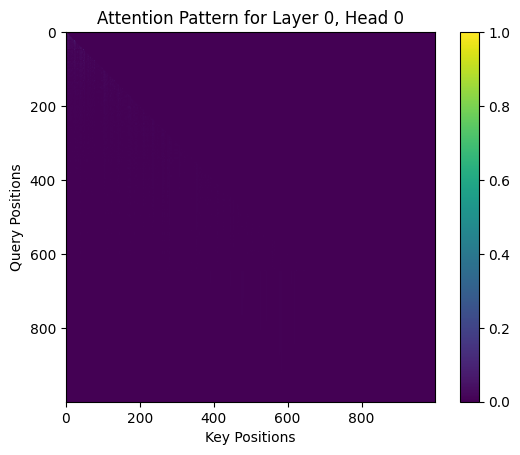

In [67]:
# Collect attention patterns
with torch.no_grad():
    logits, cache = hooked_model.run_with_cache(x)

# Choose the layer and head to visualize
layer = 0  # Change to the desired layer index
head = 0   # Change to the desired head index

# Access attention patterns for the specified layer
attn_patterns = cache[f'blocks.{layer}.attn.hook_pattern']  # Shape: [batch_size, n_heads, seq_len, seq_len]

# Extract the attention pattern for the specified head
attn = attn_patterns[0, head].cpu().numpy()  # Shape: [seq_len, seq_len]

# Visualize the attention pattern
plt.imshow(attn, cmap='viridis')
plt.colorbar()
plt.title(f'Attention Pattern for Layer {layer}, Head {head}')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()